In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT, windows
import librosa
import torch

: 

In [2]:
from sklearn.preprocessing import LabelEncoder

/Users/maxiabdala/opt/anaconda3/envs/seriesTemporales/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Lectura de datos 

In [4]:
os.chdir('/Users/maxiabdala/Documents/Python/repositorio Maxi/series_temporales_maxi/trabajo_final/codigo')

In [5]:
# vemos los archivos de audio
data_folder = os.path.join('data', 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase auto tiene 3 elementos
La clase moto tiene 3 elementos
La clase camioneta tiene 0 elementos
La clase colectivo tiene 5 elementos


## Preparacion de los datos

In [6]:
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(400), hop=400, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws #crea los timestamps
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()

    return SFT.f, ts[::ws], Sx

# Para hacer un entrenamiento vamos a utilizar como features los espectrogramas


In [7]:
# para hacer un entrenamiento vamos a utilizar como features los espectrogramas
ws = 220            # Ancho de la ventana temporal
spects = {}         # creamos listas vacías
for k in data.keys():
    spects[k] = spects.get(k, [])

# llenamos las listas con espectrogramas
for k in data.keys():
    for d in data[k]:
        spec = create_specs(d, ws=400, sr = 22050)
        spects[k].append(spec)

In [8]:
# poniendo todos los datos como una lista
train_x = []
labels = []
for k in spects.keys():
    for s in spects[k]:
        train_x.append(s[2])
        labels.append([k])

In [9]:
print(labels)

[['auto'], ['auto'], ['auto'], ['moto'], ['moto'], ['moto'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo']]


In [10]:
#obtener menor longiud para recortar espectogramas
men=train_x[0].shape[1]
for i in range (1,len(train_x)):
  if (train_x[i].shape[1]<men):
    men=train_x[i].shape[1]
print(men)

166


In [11]:
#ponemos todos los espectogramas con el mismo largo
train=[]
for i in range (len(train_x)):
  tam=train_x[i].shape[1]
  if (tam!=men):
    train.append(train_x[i][:,tam//2-men//2:tam//2+(men//2)+1])
  else:
    train.append(train_x[i])

# Printear los espectogramas


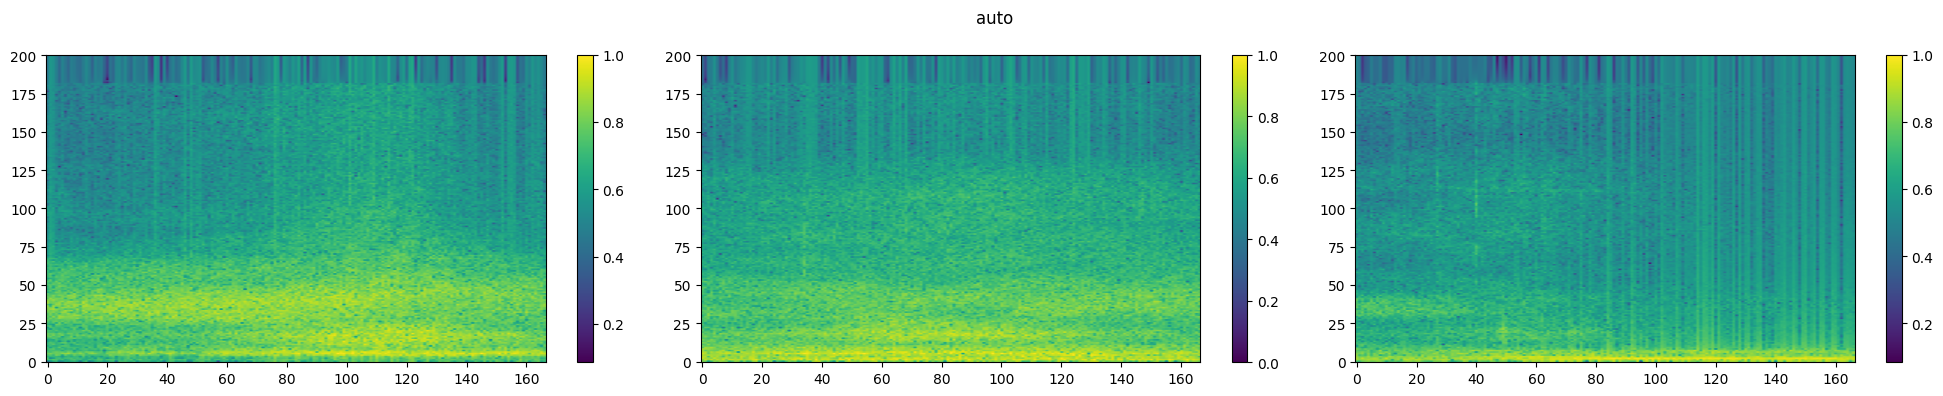

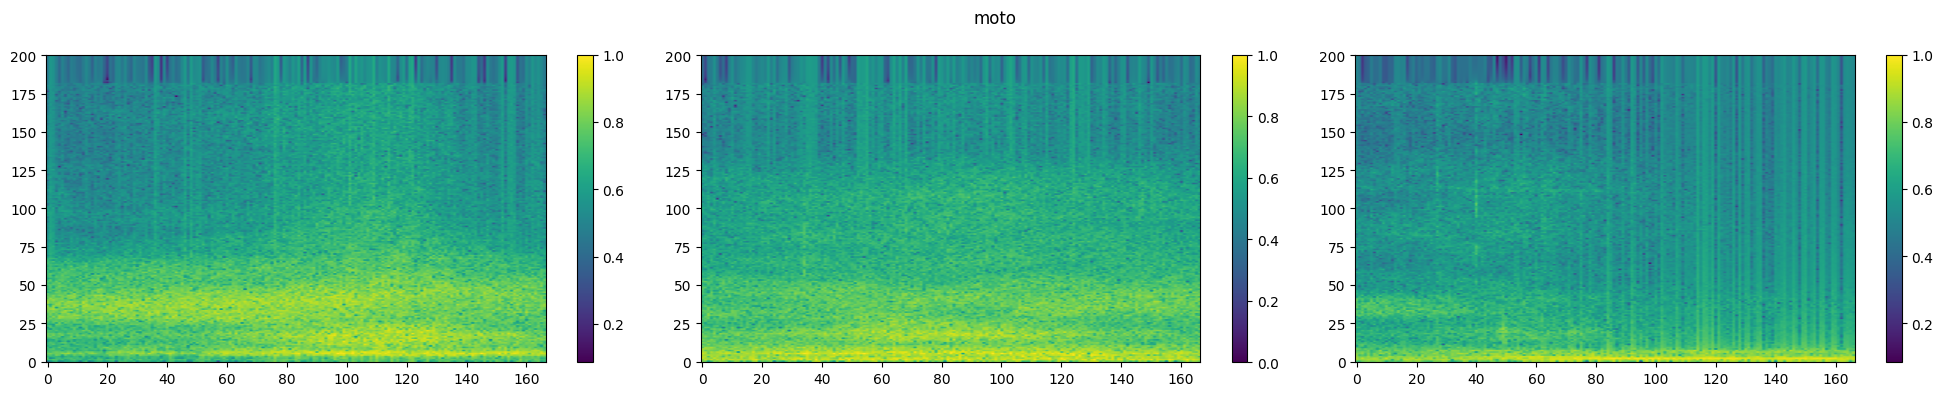

<Figure size 2000x400 with 0 Axes>

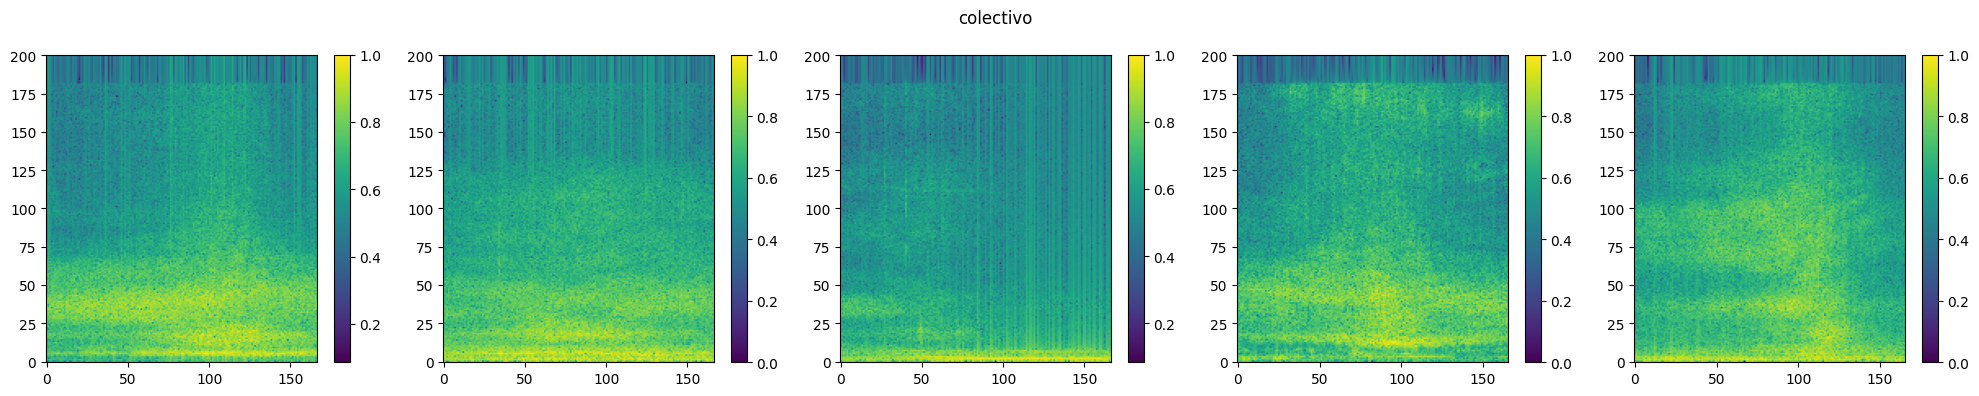

In [12]:
for k in spects.keys():
    plt.figure(figsize=(20,4))
    j=0
    for i in range(len(spects[k])):
        j+=1
        plt.subplot(1, len(spects[k]),j)
        plt.imshow(train[i], origin='lower', aspect='auto', interpolation=None) #extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]],
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

# Model combinado CNN + LSTM

In [13]:
# Definimos un modelo
class CNN_LSTM(torch.nn.Module):
    def __init__(self, num_f,num_c):
        super().__init__()
        #********CNN********#
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=32,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)
                                     )
        self.drop = torch.nn.Dropout(0.25)
        # 32, 201*111
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 32, achica en 2 la dimensión
        self.conv2 = torch.nn.Conv2d(in_channels = 32,
                                     out_channels=64,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)
                                     )
        # 64, misma dimesión despues de max pool
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        #64, achica en 2 la dimensión
        self.lin   = torch.nn.Linear(in_features = 64*(num_f//4)*(num_c//4),
                                     out_features = 32)
        #********LSTM********#
        self.lstm = torch.nn.LSTM(input_size  = 32,
                                  hidden_size = 64,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 2* 64, #se multiplica por 2 por ser bidireccional
                                     out_features = 4)


    def forward(self, x):
        #********CNN********#
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(0)
        x = self.lin(x)
        #********LSTM********#
        x= x[None,None,:]
        x, _ = self.lstm(x)
        x = self.fcon(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

In [14]:
#Como todos los espectogramas tienen la misma dimensión, tomamos las
#dimensiones del primero para crear el modelo
num_f=train[0].shape[0]
num_c=train[0].shape[1]
cmodel = CNN_LSTM(num_f,num_c).to(device)

# Creamos el encoder


In [15]:
enc = LabelEncoder()
# transformamos y tenemos nuestros ground truth
train_y = enc.fit_transform(labels).reshape(-1,1)

/Users/maxiabdala/opt/anaconda3/envs/seriesTemporales/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Probar que el modelo no tenga errores de definición

In [16]:
print(len(train))


11


In [17]:
pred=cmodel(torch.from_numpy(train[10].reshape(1,num_f,num_c)).float().to(device))

In [18]:
print(pred)

tensor([[0.0337, 0.0247, 0.0611, 0.0568]], grad_fn=<SqueezeBackward1>)


# Entrenar modelo

In [19]:
# Loss function y optimizador
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cmodel.parameters(), lr = 0.0001)
hist = []

15.337815046310425
15.295554757118225
15.261086583137512
15.227147340774536
15.192069292068481
15.154267072677612
15.113042116165161
15.067164778709412
15.013251185417175
14.946878790855408
14.861422181129456
14.745603919029236
14.584373116493225
14.360609412193298
14.0636066198349
13.71243703365326
13.365713953971863
13.069447040557861
12.994558453559875
13.271635055541992
13.067943453788757
12.874351382255554
12.674546658992767
12.440665900707245
12.493722558021545
12.284379184246063
12.213739395141602
12.167094647884369
12.13361668586731
12.107516586780548
12.085590958595276
12.066509783267975
12.04947578907013
12.034086108207703
12.020034611225128
12.007150113582611
11.995315968990326
11.984421133995056
11.974343478679657
11.965037941932678
11.956408202648163
11.948397517204285
11.940950095653534
11.934015274047852
11.927550375461578
11.921507835388184
11.915854215621948
11.910561084747314
11.905591785907745
11.9009228348732
11.89652544260025
11.892384350299835
11.888474345207214
1

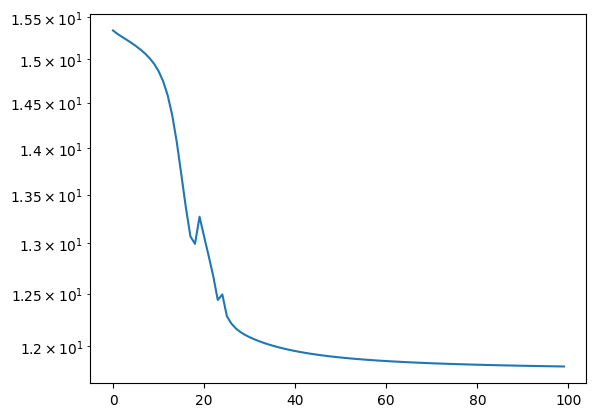

In [20]:
for epochs in range(100):
  cum = 0
  for i in range(len(train)):
    x=torch.unsqueeze(torch.from_numpy(train[i]).float(),0).to(device)
    y=torch.LongTensor(train_y[i]).to(device)
    ypred = cmodel(x)
    loss = criterion(ypred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    cum += loss.item()
  print(cum)
  hist.append(cum)
plt.semilogy(hist)

# Ajuste de hiperparametros

In [28]:
from sklearn.model_selection import ParameterGrid

# Definir los parámetros para el Grid Search
param_grid = {
    'lr': [0.0001, 0.001, 0.01],
    'epochs': [50, 100, 150]
}

# Convertir el parámetro grid en una lista de diccionarios
param_list = list(ParameterGrid(param_grid))

# Lista para almacenar los resultados de la búsqueda de cuadrícula
results = []

# Loop sobre los parámetros del grid
for params in param_list:
    # Crear una nueva instancia del modelo para cada combinación de parámetros
    cmodel = CNN_LSTM(num_f, num_c).to(device)
    
    # Definir el optimizador con el learning rate actual
    opt = torch.optim.Adam(cmodel.parameters(), lr=params['lr'])
    
    # Lista para almacenar la pérdida histórica durante el entrenamiento
    hist = []
    
    # Entrenar el modelo
    for epoch in range(params['epochs']):
        cum_loss = 0
        for i in range(len(train)):
            x = torch.unsqueeze(torch.from_numpy(train[i]).float(), 0).to(device)
            y = torch.LongTensor(train_y[i]).to(device)
            y_pred = cmodel(x)
            loss = criterion(y_pred, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            cum_loss += loss.item()
        hist.append(cum_loss)
    
    # Calcular la precisión en el conjunto de validación
    # Esto se puede hacer aquí dentro del bucle o después del bucle para cada conjunto de parámetros
    # En este caso, supongamos que lo hacemos después del bucle
    # Agregar los resultados a la lista de resultados
    results.append({
        'params': params,
        'loss_history': hist,
       # 'validation_accuracy': accuracy_on_validation_set(cmodel, X_val, y_val)  # Implementa esta función según sea necesario
    })

# Ordenar los resultados por precisión en el conjunto de validación de forma descendente
# results.sort(key=lambda x: x['validation_accuracy'], reverse=True)

# Imprimir los mejores resultados
print("Mejores parámetros:")
print(results[0]['params'])


Mejores parámetros:
{'epochs': 50, 'lr': 0.0001}


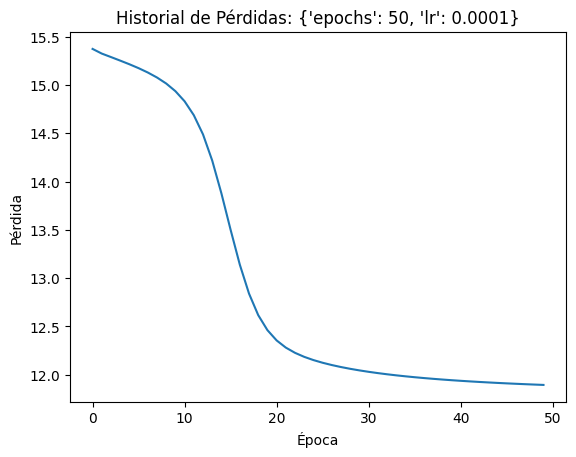

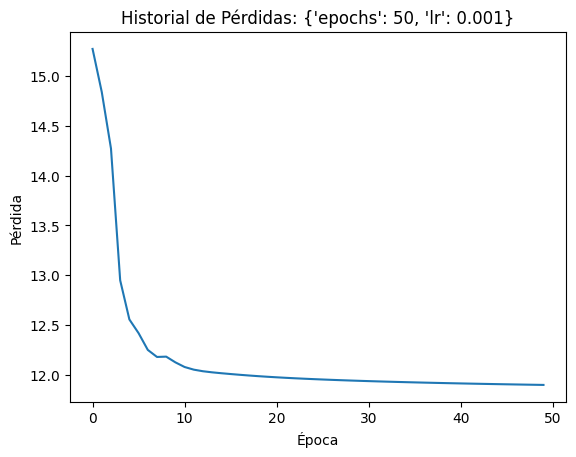

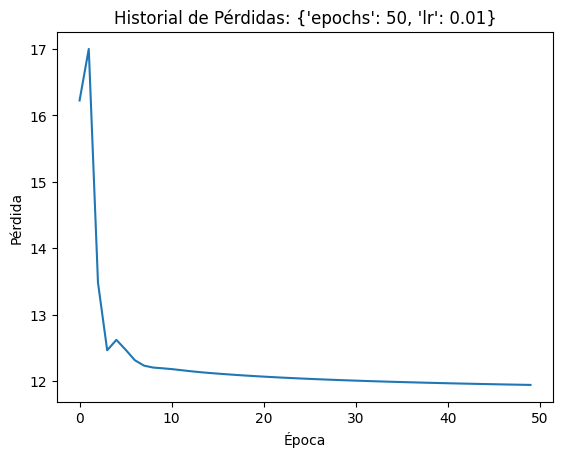

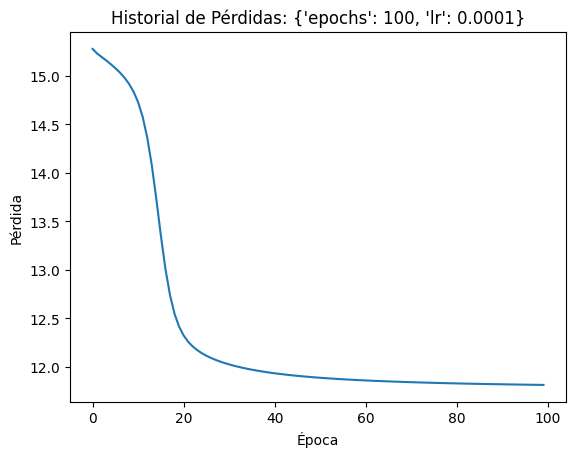

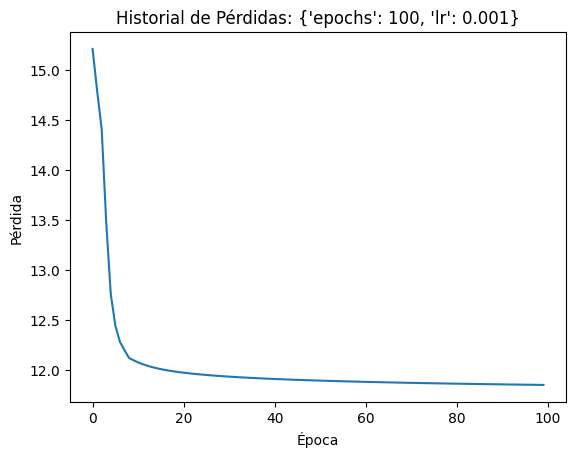

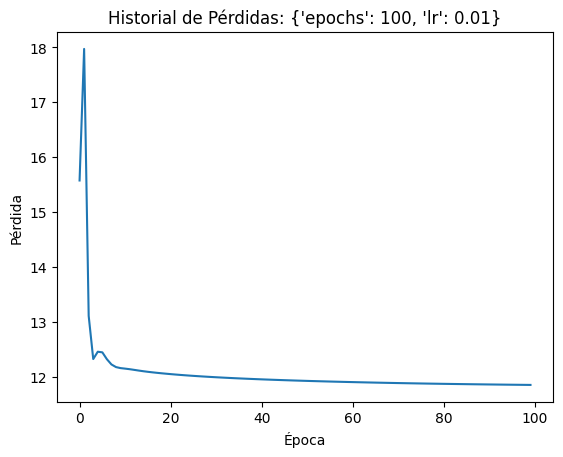

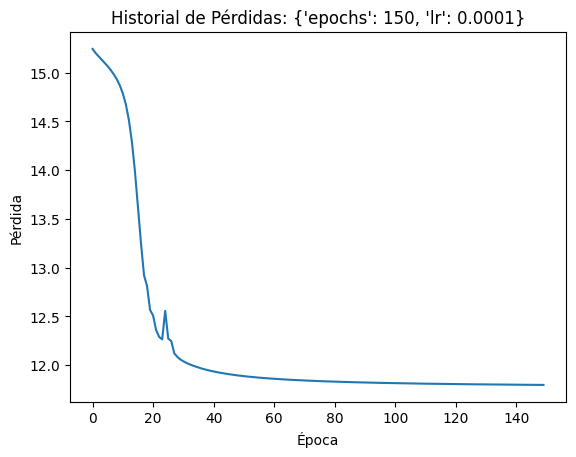

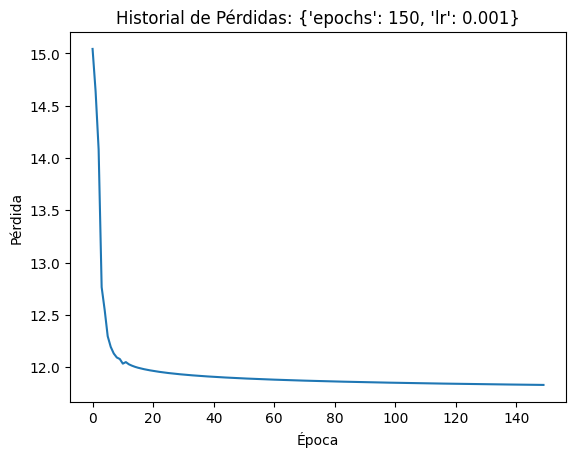

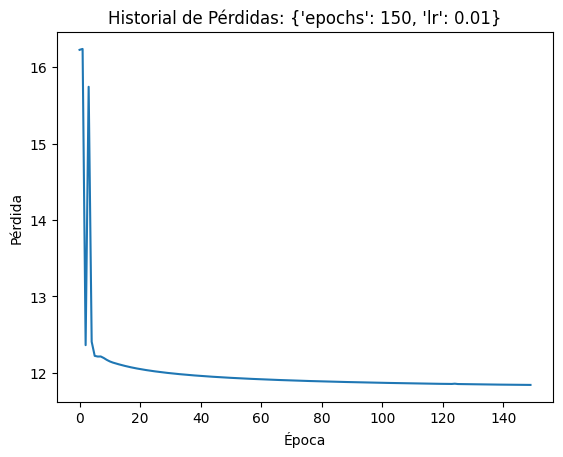

In [35]:
for result in results:
    best_loss_history = result['loss_history']
    plt.plot(best_loss_history)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title(f'Historial de Pérdidas: {result["params"]}')
    plt.show()
